Using Client Data to Predict Bank Customer Churn

Goal: Analyze the relationship between a bank customers account information and whether or not they exited their account. I intend to answer the question on what factors drive customers to leave versus stay with their current financial institution. 

Data Problem: The task is to train and tune multiple classification models that can classify whether a customer churned or not.

Expected Results: The expected result of this project is a quality model with high recall that can be used to predict, from account and categorical data, whether .

We will draw insights from the various models based on the nature of the model and its recall score. For example; in logistic regression we would see which factor coefficients drive the target of churn. 

Data

The data is sourced from Kaggle.

Link: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn?resource=download

The data is a collection from multiple banks within the european union. The currency values are therefore in euros. 
The dataset has information about a client demographics like gender and location, and also thier financials like credit score and account value. 

# Import and Setup

In [1]:
import pandas as pd
import seaborn as sns 
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import recall_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

import time



# Data Overview

In [2]:
df = pd.read_csv("C:/Users/micls/OneDrive/Desktop/UC Berkelely AI CLASS/data/wa_churn.csv")
df = df.drop('customerID', axis =1)

In [3]:
print(df.shape)
df.head()

(7032, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


Distribution

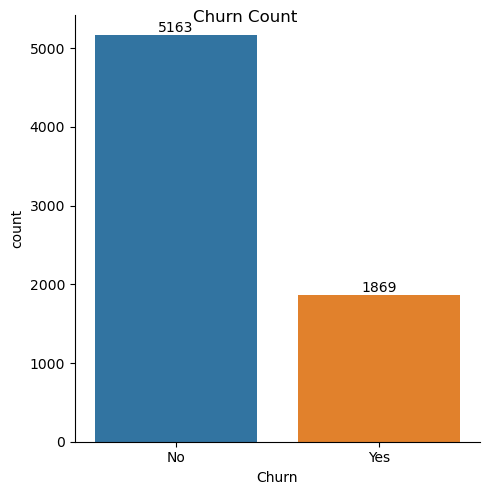

In [5]:
#checking churn distribution 
#the data is unbalanced, precision is the best scorer. 

fig = sns.catplot(x = 'Churn', kind = 'count', data = df)
fig.fig.suptitle("Churn Count")
for fig in fig.axes.flat:
    fig.bar_label(fig.containers[0])

Setup

In [6]:
#drop the clients with no internet or phone access, make yes/no binary, make male/female binary, 
df = df[df['DeviceProtection'] != 'No internet service']
df = df[df['MultipleLines'] != 'No phone service']

mapping = {'Yes': 1, 'No': 0}
df['Partner'] = df['Partner'].map(mapping)
df['Dependents'] = df['Dependents'].map(mapping)
df['PhoneService'] = df['PhoneService'].map(mapping)
df['OnlineSecurity'] = df['OnlineSecurity'].map(mapping)
df['OnlineBackup'] = df['OnlineBackup'].map(mapping)
df['DeviceProtection'] = df['DeviceProtection'].map(mapping)
df['TechSupport'] = df['TechSupport'].map(mapping)
df['StreamingTV'] = df['StreamingTV'].map(mapping)
df['StreamingMovies'] = df['StreamingMovies'].map(mapping)
df['PaperlessBilling'] = df['PaperlessBilling'].map(mapping)
df['MultipleLines'] = df['MultipleLines'].map(mapping)
df['Churn'] = df['Churn'].map(mapping)

mapping = {'Male': 1, 'Female': 0}
df['gender'] = df['gender'].map(mapping)

In [7]:
#One-Hot Encoding
dummies = pd.get_dummies(df['Contract'])
df = pd.concat([df, dummies], axis=1).drop('Contract',axis = 1)
dummies = pd.get_dummies(df['InternetService'])
df = pd.concat([df, dummies], axis=1).drop('InternetService',axis = 1)
dummies = pd.get_dummies(df['PaymentMethod'])
df = pd.concat([df, dummies], axis=1).drop('PaymentMethod',axis = 1)

In [8]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Churn,Month-to-month,One year,Two year,DSL,Fiber optic,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
1,1,0,0,0,34,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,...,1,1,0,0,1,0,0,0,0,1
4,0,0,0,0,2,1,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
5,0,0,0,0,8,1,1,0,0,1,...,1,1,0,0,0,1,0,0,1,0
6,1,0,0,1,22,1,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0


In [9]:
#train test split
X = df.drop('Churn', axis = 1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4832 entries, 1 to 7031
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     4832 non-null   int64  
 1   SeniorCitizen              4832 non-null   int64  
 2   Partner                    4832 non-null   int64  
 3   Dependents                 4832 non-null   int64  
 4   tenure                     4832 non-null   int64  
 5   PhoneService               4832 non-null   int64  
 6   MultipleLines              4832 non-null   int64  
 7   OnlineSecurity             4832 non-null   int64  
 8   OnlineBackup               4832 non-null   int64  
 9   DeviceProtection           4832 non-null   int64  
 10  TechSupport                4832 non-null   int64  
 11  StreamingTV                4832 non-null   int64  
 12  StreamingMovies            4832 non-null   int64  
 13  PaperlessBilling           4832 non-null   int64

# Model Training

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#Logistic regression
lgr = Pipeline([('lgr', LogisticRegression())])


lgr_params = {'lgr__penalty' : ['l2', 'l1'],
             'lgr__fit_intercept' : [True, False],
             'lgr__C': [0.01, 0.1, 1, 10, 100]}
lgr_grid = GridSearchCV(lgr, lgr_params, cv=5)

start = time.time()
lgr_grid.fit(X_train_scaled, y_train)
stop = time.time()
lgr_params = lgr_grid.best_params_

lgr_time = stop - start
lgr_rec = recall_score(y_test, lgr_grid.predict(X_test_scaled))

C:\Users\micls\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty,

In [11]:
lgr_rec

0.601010101010101

In [12]:
#SVC, takes too long to run
#svc = Pipeline([ ('svc', SVC(kernel = 'linear'))])
#
#svc_params = {'svc__C' : [1],
#             'svc__probability' : [True, False]}
#
#svc_grid = RandomizedSearchCV(estimator = svc,
#                   param_distributions = svc_params,
#                             scoring = 'recall')
#
#start = time.time()
#svc_grid.fit(X_train, y_train)
#stop = time.time()
#
#svc_time = stop - start
#svc_params = svc_grid.best_params_
#svc_rec = recall_score(y_test, svc_grid.predict(X_test))


In [13]:
#decision tree
dtree = Pipeline([('tree', DecisionTreeClassifier())])

dtree_params = {'tree__criterion' : ['gini', 'entropoy'],
              'tree__max_depth' : [None, 1, 2, 3, 4],
              'tree__min_samples_split' : [1, 2, 3, 4]}

dtree_grid = RandomizedSearchCV(estimator = dtree,
                   param_distributions = dtree_params,
                              scoring = 'recall')

start = time.time()
dtree_grid.fit(X_train, y_train)
stop = time.time()

dtree_time = stop - start
dtree_params = dtree_grid.best_params_
dtree_rec = recall_score(y_test, dtree_grid.predict(X_test))

C:\Users\micls\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\micls\anaconda3\Lib\site-packa

In [14]:
#naive bayes
bayes = Pipeline([('bayes', MultinomialNB())])

bayes_params = {'bayes__alpha' : [1, 0.1, 0.01, 0.001, 0]}

bayes_grid = RandomizedSearchCV(estimator = bayes,
                            param_distributions = bayes_params,
                               scoring = 'recall')

start = time.time()
bayes_grid.fit(X_train, y_train)
stop = time.time()

bayes_time = stop - start
bayes_params = bayes_grid.best_params_
bayes_rec = recall_score(y_test, bayes_grid.predict(X_test))

C:\Users\micls\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\micls\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\micls\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
C:\Users\micls\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\micls\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:635:

In [15]:
#KNN
knn = Pipeline([('knn', KNeighborsClassifier())])

knn_params = {'knn__n_neighbors' : [ 2, 3, 4, 5]}

knn_grid = RandomizedSearchCV(estimator = knn,
                            param_distributions = knn_params,
                               scoring = 'recall')

start = time.time()
knn_grid.fit(X_train, y_train)
stop = time.time()

knn_time = stop - start
knn_params = knn_grid.best_params_
knn_rec = recall_score(y_test, knn_grid.predict(X_test))

C:\Users\micls\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


# Evaluation

In [16]:
results = pd.DataFrame({'model': ['Logistic Regression', 'Decision Tree', 'Naive Bayes','KNN'], 
              'speed' : [lgr_time, dtree_time, bayes_time, knn_time],
              'best_params': [lgr_params, dtree_params, bayes_params, knn_params],
              'recall' : [lgr_rec, dtree_rec, bayes_rec, knn_rec]}).set_index('model')

In [17]:
results

,speed,best_params,recall
model,,,
Logistic Regression,0.821099,"{'lgr__C': 100, 'lgr__fit_intercept': True, 'l...",0.601010
Decision Tree,0.366432,"{'tree__min_samples_split': 4, 'tree__max_dept...",0.729798
Naive Bayes,0.762894,{'bayes__alpha': 1},0.767677
KNN,2.550412,{'knn__n_neighbors': 3},0.489899


Naive bayes scores highest, Decision Tree 2nd, Logistic Regression still good. 

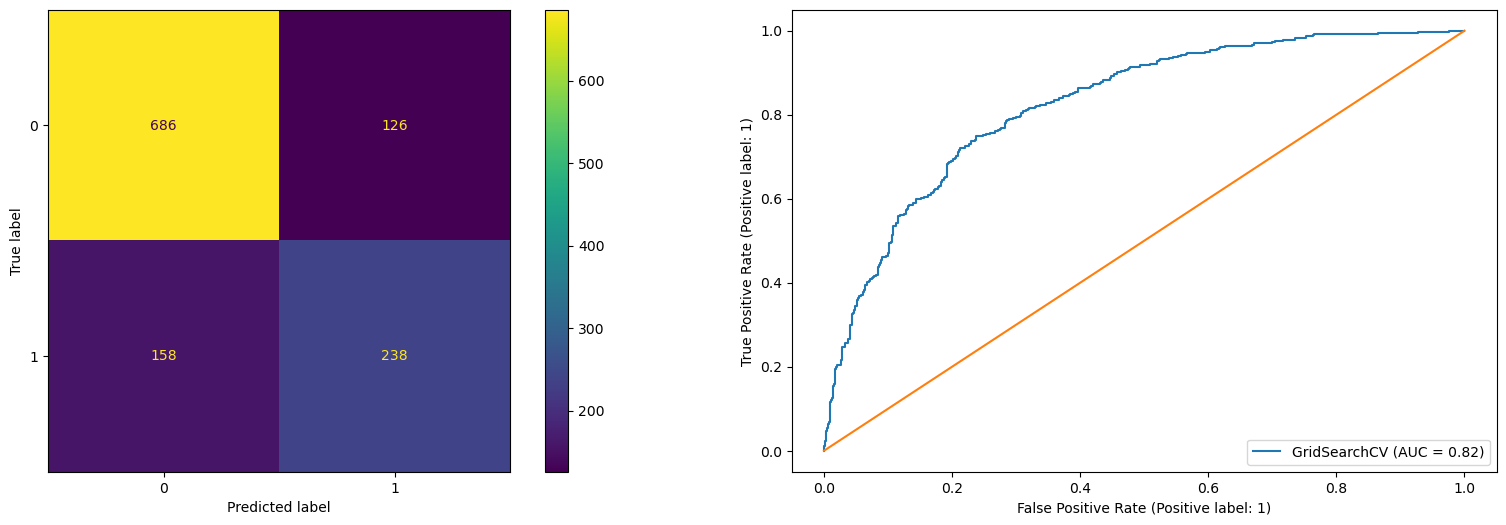

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(lgr_grid, X_test_scaled, y_test, ax = ax[0])  #confusion matrix and ROC chart maker
RocCurveDisplay.from_estimator(lgr_grid, X_test_scaled, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

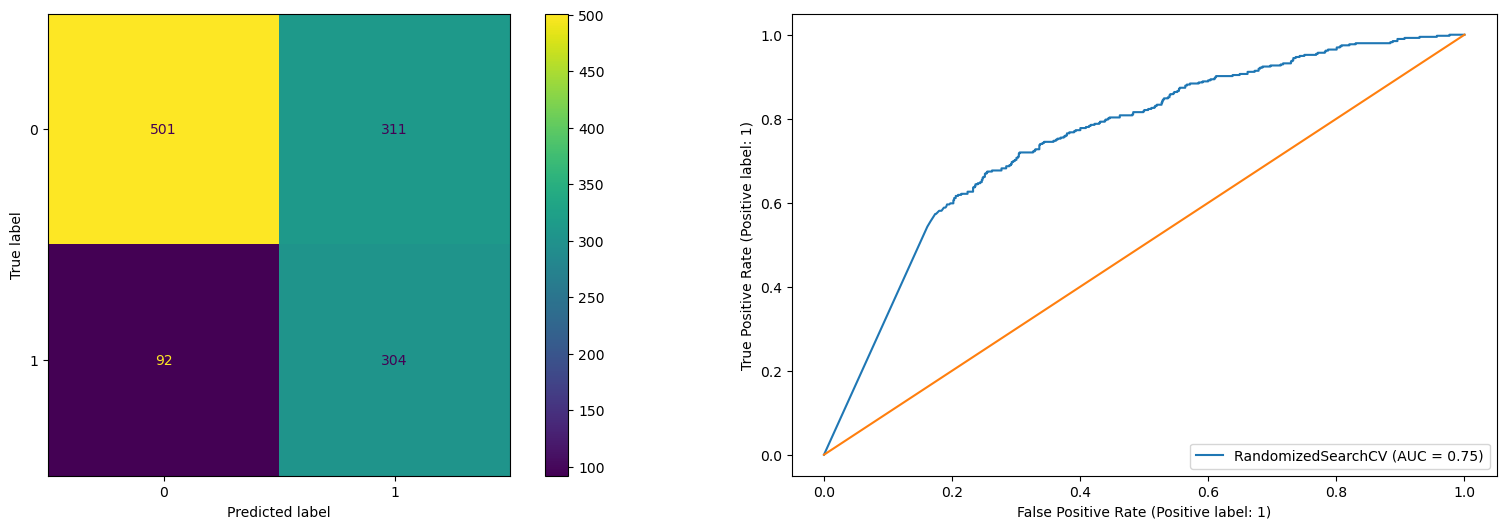

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(bayes_grid, X_test, y_test, ax = ax[0])  #confusion matrix and ROC chart maker
RocCurveDisplay.from_estimator(bayes_grid, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

The most important feature to predict turn are tenure, total & monthly charges. We can also see that clients who use the more modern services like paperless billing, fiber optic, electronic check, etc. also churn less than those who use mailed check, have dependants, or even have a credit card. 

In [25]:
lgr_params

{'lgr__C': 100, 'lgr__fit_intercept': True, 'lgr__penalty': 'l2'}

<Axes: ylabel='Feature'>

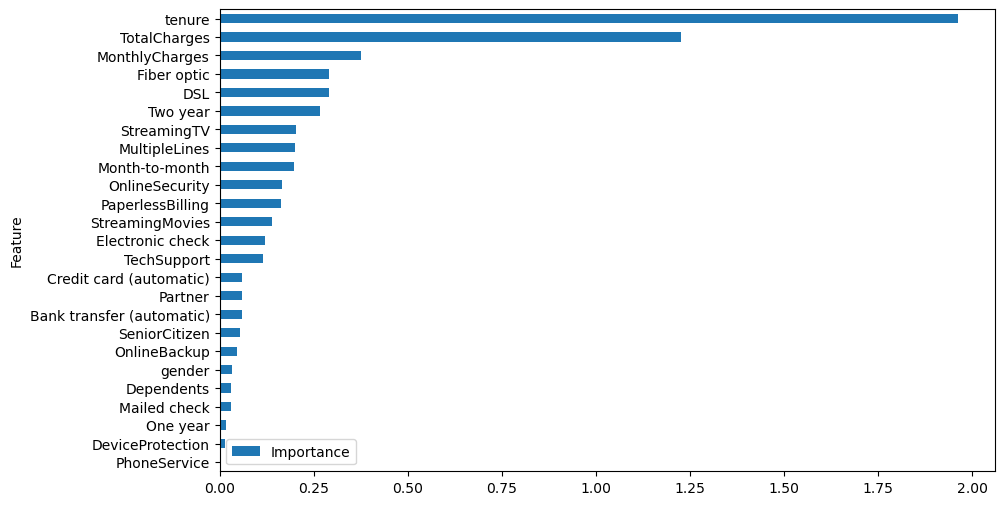

In [26]:
lgr = LogisticRegression(C = 100, fit_intercept = True , penalty = 'l2').fit(X_train_scaled, y_train)# best params from grid search
coefficients = lgr.coef_[0]
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [27]:
dtree_params

{'tree__min_samples_split': 4, 'tree__max_depth': 4, 'tree__criterion': 'gini'}

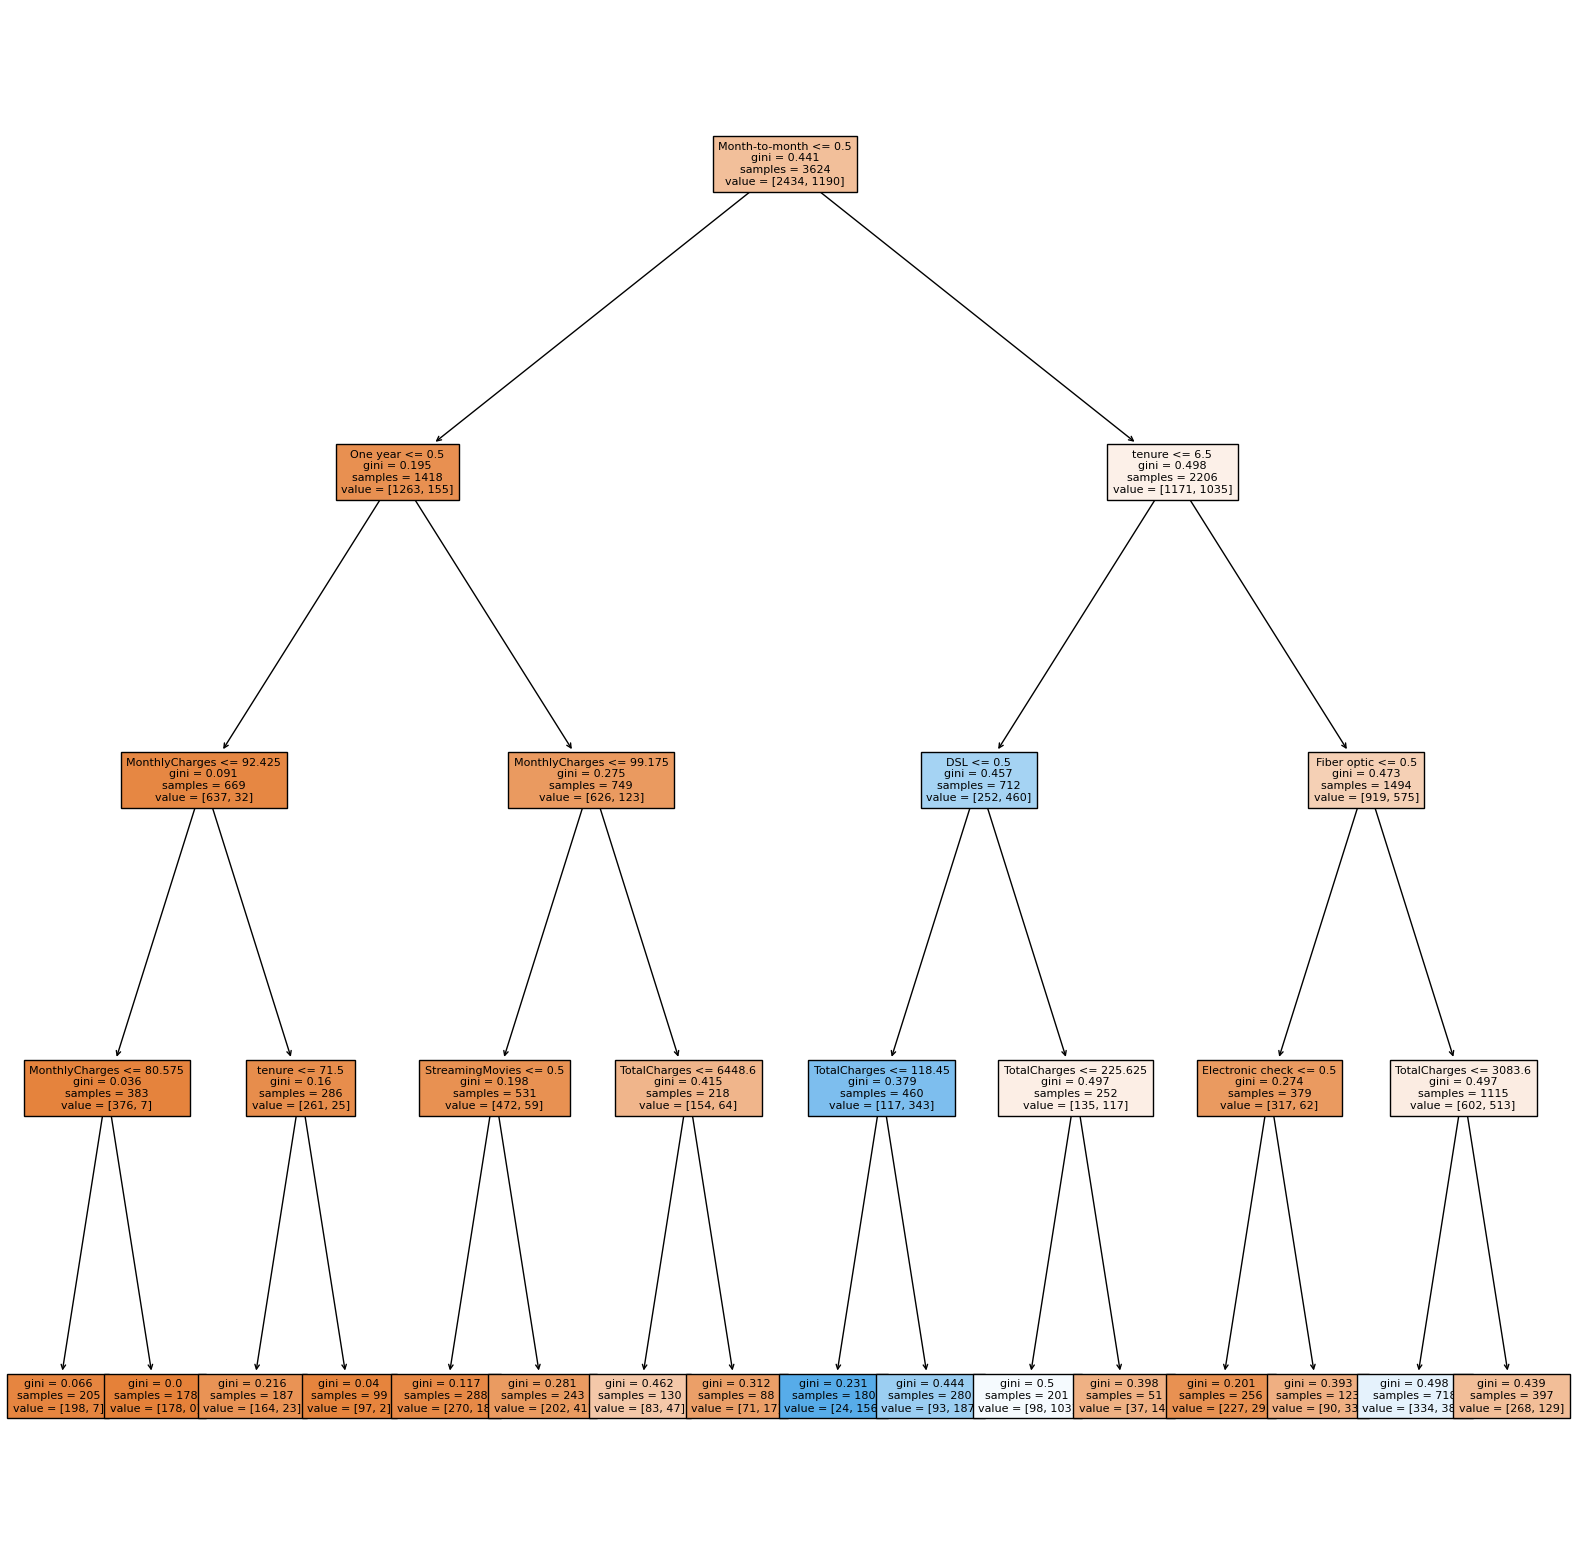

In [28]:
tree = DecisionTreeClassifier(max_depth = 4, criterion = 'gini', min_samples_split = 4).fit(X_train, y_train)# best params from grid search
fig, ax = plt.subplots(figsize = (20, 20))
plot_tree(tree, feature_names=list(X.columns), filled=True, ax = ax, fontsize=8);

Month to month , tenure, and two year are good subsets of clients to look into what else determines their churn. 